## Dealing with missing data and lift rate effects

In [1]:
import pymc as pm
import pandas as pd
import itertools as itt
import arviz as az
import graphviz
import numpy as np
import importlib as imp

In [2]:
melted_df = pd.read_csv("melted_data.csv")
df = pd.read_csv("data.csv")


In [29]:
full_obs = df.copy()

def mask_nans(y):
    x = y.copy()
    x = np.nan_to_num(x, nan = -1)
    return np.ma.masked_values(x, value = -1) 

#lift rates
int_lift_rates = mask_nans(full_obs['Intervention Average Lift Rate'].values.reshape(-1, 1))
base_lift_rates = mask_nans(full_obs['Baseline Average Lift Rate'].values.reshape(-1, 1))

#scores
int_scores = mask_nans(full_obs['Intervention Average Safety Score'].values.reshape(-1, 1))
base_scores = mask_nans(full_obs['Baseline Average Safety Score'].values.reshape(-1, 1))

#treatments
int_treatments = pd.get_dummies(full_obs['Haptic Group'])
tr_names = int_treatments.columns
treatments = int_treatments.values
tr_names

Index(['2 bends in 10 minutes', '2 bends in 5 minutes',
       '3 bends in 8 minutes'],
      dtype='object')

In [30]:
with pm.Model() as m:
    
    #register the data
    scores = pm.ConstantData("scores", np.concatenate([base_scores, int_scores]))
    #i_scores = pm.ConstantData("intervention_scores", int_scores)
    
    b_rates = pm.ConstantData("baseline_rates", base_lift_rates)
    i_rates = pm.ConstantData("intervention_rates", int_lift_rates)
    
    treats = pm.ConstantData("treatments", treatments)
    no_treats = pm.ConstantData("baseline", np.zeros(treatments.shape))
    
    #priors
    α = pm.Normal("lift_alpha", 0, sigma=10)
    lift_treatment = pm.Normal("lift_treatment", 0, sigma=10, shape=(treatments.shape[1], 1))
    ind_effect_sigma = pm.HalfCauchy("lift_ind_error", beta=5)
    ind_effects = pm.Normal("lift_fixed", 0, sigma=ind_effect_sigma, shape=(base_lift_rates.shape[0], 1))
    
    #impute missing values for base lift rates
    imputed_base_rates = pm.Normal("lift_base", mu=i_rates, sigma=40, observed=b_rates)
    
    #obtain impact of treatment to lift scores    
    pred_lift_rates = imputed_base_rates + ind_effects + pm.math.dot(treats, lift_treatment)
    
    #estimate intervention lift rates
    residual_var = pm.HalfCauchy("lift_error", beta=5)
    est_int_rates = pm.Normal('lift_int', mu=pred_lift_rates, sigma = residual_var, observed = i_rates)
    
    #stack the data together
    lift_rates_stacked = pm.math.concatenate([imputed_base_rates, est_int_rates], axis=0)
    treatments_stacked = pm.math.concatenate([no_treats, treats], axis=0)
    
    #priors
    alpha = pm.Normal("score_alpha", 0, sigma=50)
    lift_beta = pm.Normal("score_lift", 0, sigma=10)
    treatment_betas = pm.Normal("score_treatment", 0, sigma=10, shape=(treatments.shape[1], 1))
    score_ind_effect_sigma = pm.HalfCauchy("score_ind_error", beta=5)
    fixed_effects = pm.Normal("score_fixed", 0, sigma=score_ind_effect_sigma, shape=(base_lift_rates.shape[0], 1))
    
    #stack as needed    
    fixed_effects_stacked = pm.math.concatenate([fixed_effects, fixed_effects], axis=0)
    
    #calculate score    
    s = alpha + (lift_beta * lift_rates_stacked) + fixed_effects_stacked + pm.math.dot(treatments_stacked, treatment_betas)
    
    #likelihood
    error_var = pm.HalfCauchy("score_error", beta=5)
    pm.Normal('likelihood', mu = s, sigma = error_var, observed = scores)    
    

In [31]:
with m:
    trace = pm.sample()

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (TensorType(float64, (None, 1))) must be compatible with the type of the original Variable (TensorType(float64, (418, 1))). local_gemm_to_gemv
ERROR (aesara.graph.opt): SeqOptimizer apply <aesara.graph.opt.EquilibriumOptimizer object at 0x7fdb022c8ee0>
ERROR (aesara.graph.opt): Traceback:
ERROR (aesara.graph.opt): Traceback (most recent call last):
  File "/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/aesara/graph/opt.py", line 280, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/aesara/graph/opt.py", line 103, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/aesara/graph/opt.py", line 2329, in apply
    lopt_change = self.process_node(fgraph, node, lopt)
  File "/home/aurimas/apps/anaconda3/envs

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (TensorType(float64, (None, 1))) must be compatible with the type of the original Variable (TensorType(float64, (418, 1))). local_gemm_to_gemv
ERROR (aesara.graph.opt): SeqOptimizer apply <aesara.graph.opt.EquilibriumOptimizer object at 0x7fdb022c8ee0>
ERROR (aesara.graph.opt): Traceback:
ERROR (aesara.graph.opt): Traceback (most recent call last):
  File "/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/aesara/graph/opt.py", line 280, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/aesara/graph/opt.py", line 103, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/aesara/graph/opt.py", line 2329, in

In [32]:
results = az.summary(trace, hdi_prob=0.95)
rel_idx = [i for i in results.index if 'fixed' not in i]
results.loc[rel_idx, :]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lift_alpha,0.338,9.875,-19.017,20.080,0.130,0.192,5745.0,2557.0,1.00
"lift_treatment[0, 0]",-5.509,2.479,-10.205,-0.551,0.055,0.039,2030.0,2429.0,1.00
"lift_treatment[1, 0]",-9.837,2.275,-14.096,-5.216,0.049,0.035,2159.0,2612.0,1.00
"lift_treatment[2, 0]",-9.042,2.462,-13.889,-4.187,0.065,0.049,1437.0,1817.0,1.00
score_alpha,79.074,0.964,77.237,80.944,0.024,0.017,1646.0,2407.0,1.00
score_lift,-0.116,0.009,-0.132,-0.098,0.000,0.000,1740.0,2312.0,1.00
"score_treatment[0, 0]",0.676,0.442,-0.178,1.572,0.007,0.006,3635.0,1886.0,1.00
"score_treatment[1, 0]",0.664,0.412,-0.168,1.439,0.007,0.005,3320.0,1267.0,1.00
"score_treatment[2, 0]",-0.381,0.426,-1.202,0.448,0.007,0.005,3897.0,3129.0,1.00
lift_ind_error,12.399,6.561,2.037,21.328,1.894,1.373,12.0,23.0,1.25


In [28]:
results = az.summary(trace, hdi_prob=0.95)
rel_idx = [i for i in results.index if 'fixed' not in i]
results.loc[rel_idx, :]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lift_alpha,-0.856,9.768,-19.447,18.323,0.318,0.225,919.0,1765.0,1.01
"lift_treatment[0, 0]",-5.164,4.576,-14.365,3.316,0.146,0.103,1017.0,1191.0,1.01
"lift_treatment[1, 0]",-18.454,4.697,-27.074,-8.951,0.195,0.138,635.0,385.0,1.01
"lift_treatment[2, 0]",-12.612,4.779,-21.835,-3.360,0.189,0.134,647.0,852.0,1.01
score_alpha,22.446,2.274,18.088,26.887,0.119,0.084,390.0,111.0,1.02
score_lift,0.427,0.021,0.386,0.467,0.001,0.001,320.0,1091.0,1.01
"score_treatment[0, 0]",1.566,1.848,-2.150,5.003,0.060,0.042,980.0,268.0,1.01
"score_treatment[1, 0]",2.304,1.792,-1.358,5.763,0.127,0.121,311.0,113.0,1.02
"score_treatment[2, 0]",0.782,1.774,-2.515,4.369,0.050,0.035,1269.0,1743.0,1.00
lift_ind_error,10.677,9.379,0.970,34.476,3.353,2.466,6.0,13.0,1.87


array([[<AxesSubplot:title={'center':'lift_alpha'}>,
        <AxesSubplot:title={'center':'lift_alpha'}>],
       [<AxesSubplot:title={'center':'lift_treatment'}>,
        <AxesSubplot:title={'center':'lift_treatment'}>],
       [<AxesSubplot:title={'center':'lift_fixed'}>,
        <AxesSubplot:title={'center':'lift_fixed'}>],
       [<AxesSubplot:title={'center':'score_alpha'}>,
        <AxesSubplot:title={'center':'score_alpha'}>],
       [<AxesSubplot:title={'center':'score_lift'}>,
        <AxesSubplot:title={'center':'score_lift'}>],
       [<AxesSubplot:title={'center':'score_treatment'}>,
        <AxesSubplot:title={'center':'score_treatment'}>],
       [<AxesSubplot:title={'center':'score_fixed'}>,
        <AxesSubplot:title={'center':'score_fixed'}>],
       [<AxesSubplot:title={'center':'lift_error'}>,
        <AxesSubplot:title={'center':'lift_error'}>],
       [<AxesSubplot:title={'center':'score_error'}>,
        <AxesSubplot:title={'center':'score_error'}>]], dtype=object

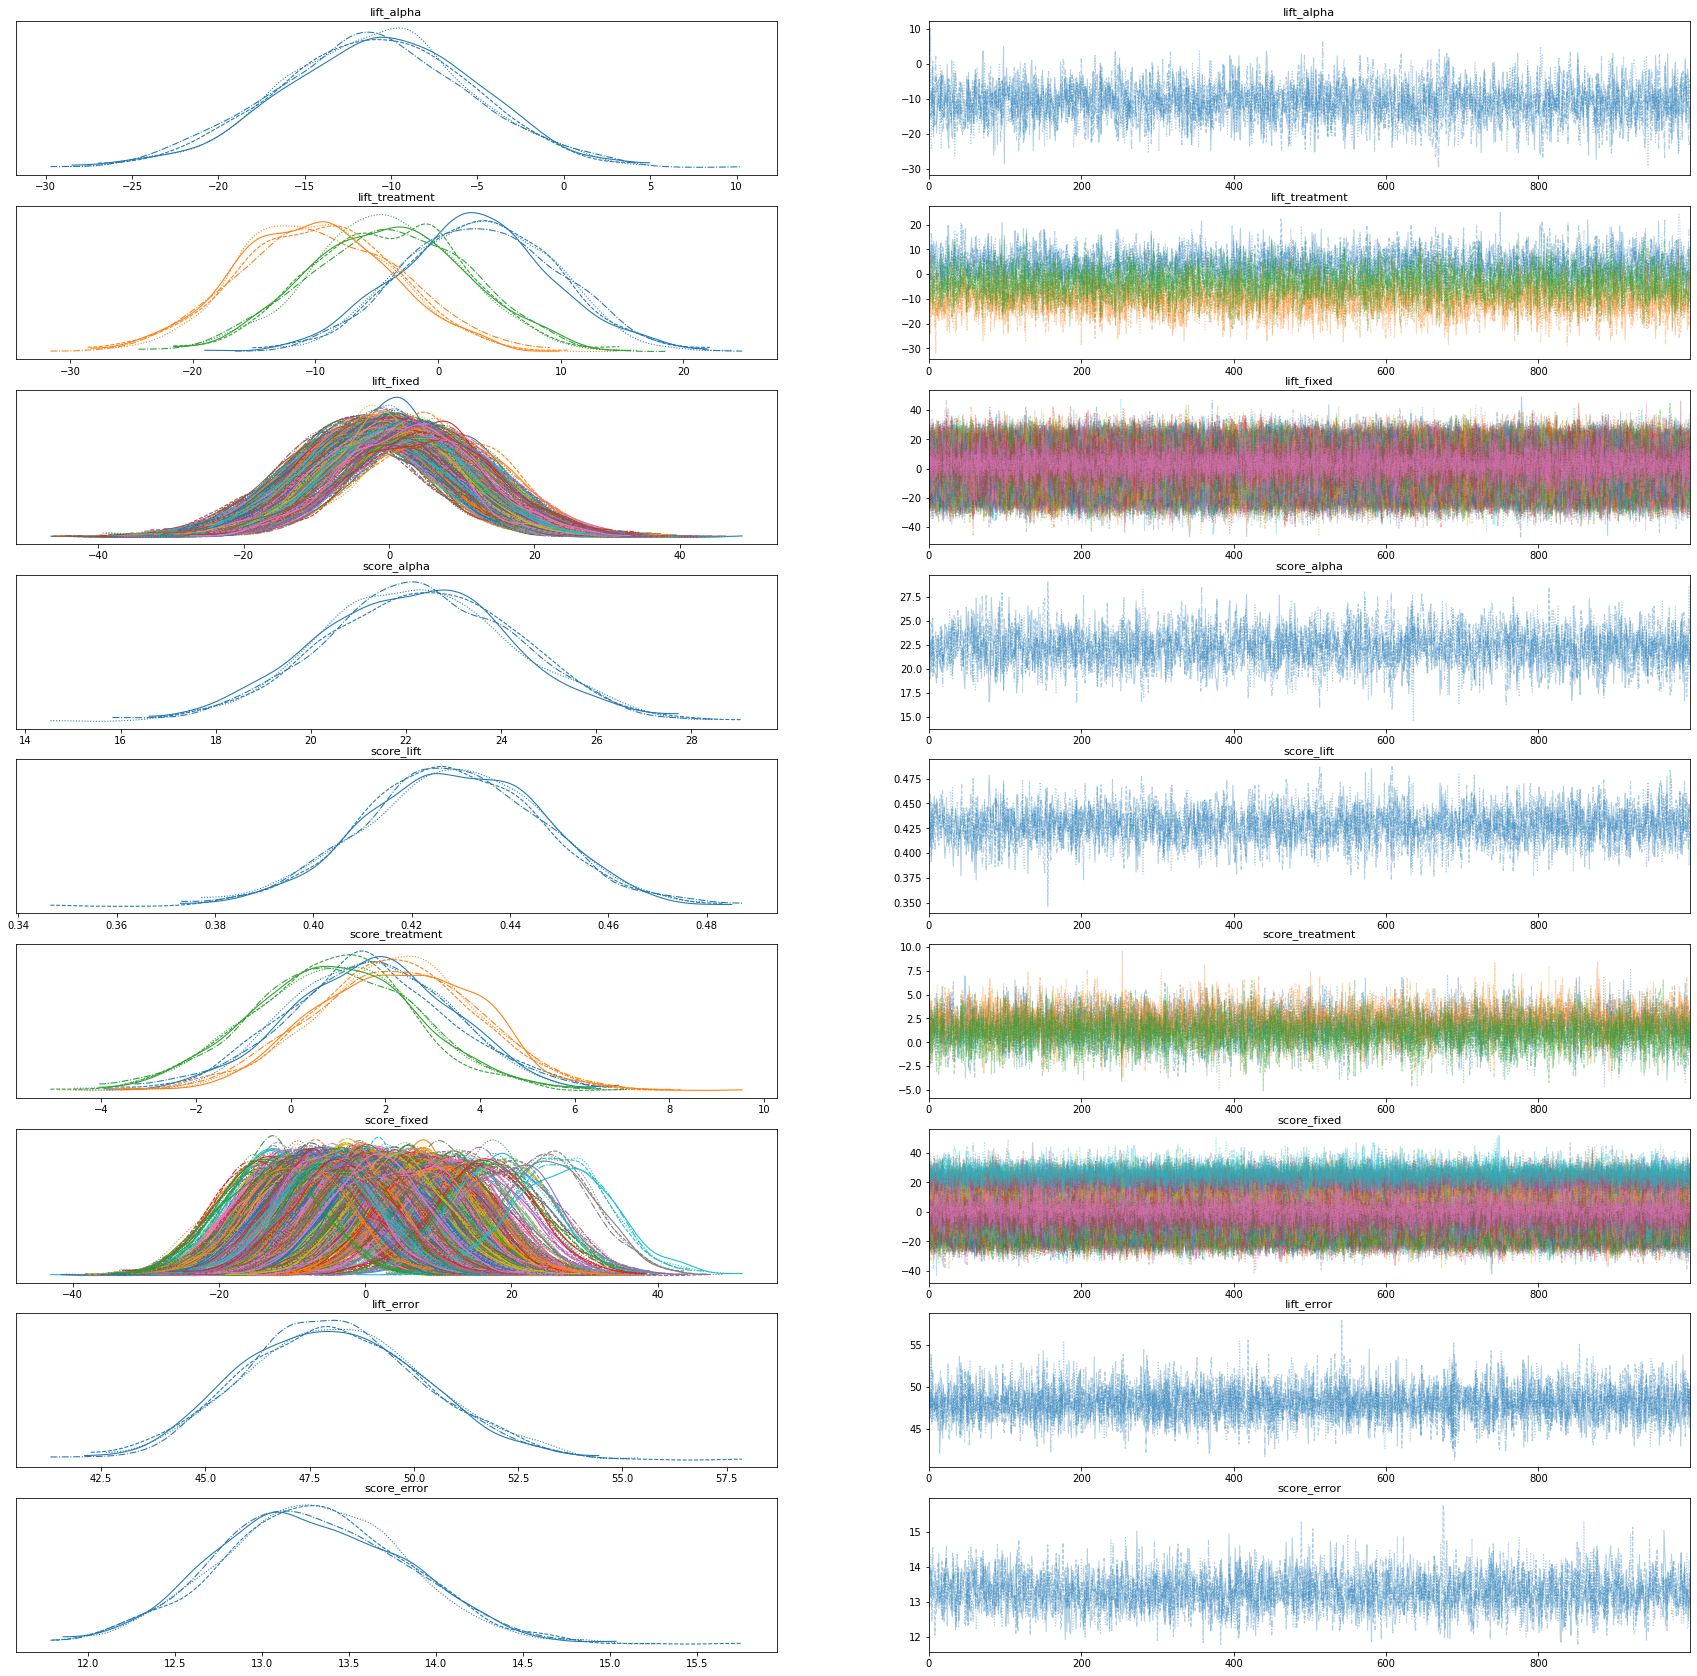

In [7]:
az.plot_trace(trace, figsize=(30,30))